# CASTING DEFECT DETECTION USING CNNS
* These all photos are top view of submersible pump impeller.
* The dataset contains total 7348 image data. These all are the size of (300*300) pixels grey-scaled images. In all images, augmentation already applied.
* There are mainly two categories:-
 * Defective
 * Ok

In [ ]:
!unzip /content/drive/MyDrive/archive.zip -d /content/drive/MyDrive/archive_2

In [3]:
!pip install tensorflow==2.19.0

In [12]:
import os
print(os.listdir("/content/drive/MyDrive/archive_2/casting_data/casting_data/train"))

['def_front', 'ok_front']


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import cv2

In [ ]:
!pip install tqdm

In [14]:
OK_DIR = "/content/drive/MyDrive/archive_2/casting_data/casting_data/train/ok_front/"
DEF_DIR = "/content/drive/MyDrive/archive_2/casting_data/casting_data/train/def_front/"
okay = os.listdir(OK_DIR)
defective = os.listdir(DEF_DIR)

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
okay_paths = []
for i in tqdm(range(0, len(okay))):
    okay_path = OK_DIR + okay[i]
    okay_paths.append(okay_path)

defective_paths = []
for i in tqdm(range(0, len(defective))):
    defective_path = DEF_DIR + defective[i]
    defective_paths.append(defective_path)

100%|██████████| 3758/3758 [00:00<00:00, 1365401.46it/s]


In [17]:
okay_labels = np.ones(len(okay_paths)) # 1 = NON DEFECTIVE
defective_labels = np.zeros(len(defective_paths)) # 0 = DEFECTIVE

In [18]:
train_paths = np.concatenate([
    np.array(okay_paths),
    np.array(defective_paths)
])
train_labels = np.concatenate([
    okay_labels,
    defective_labels
])

In [ ]:
df = pd.DataFrame({"PATHS":train_paths, "LABELS":train_labels})
df = df.sample(frac = 1, )
df

In [20]:
paths = np.array(df.PATHS)
labels = np.array(df.LABELS)

In [21]:
from sklearn.model_selection import train_test_split
xtrain, xval, ytrain, yval = train_test_split(paths, labels, test_size = 0.2)

In [22]:
def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels = 3)
    image = tf.image.resize(image, size=(256, 256))
    image = tf.cast(image, dtype= tf.float32)/255
    return image, label

train_dataset = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
train_dataset = train_dataset.map(load_image)
train_dataset = train_dataset.shuffle(buffer_size=500)
train_dataset = train_dataset.batch(32)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((xval, yval))
val_dataset = val_dataset.map(load_image)
val_dataset = val_dataset.shuffle(buffer_size=500)
val_dataset = val_dataset.batch(32)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

train_dataset, val_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

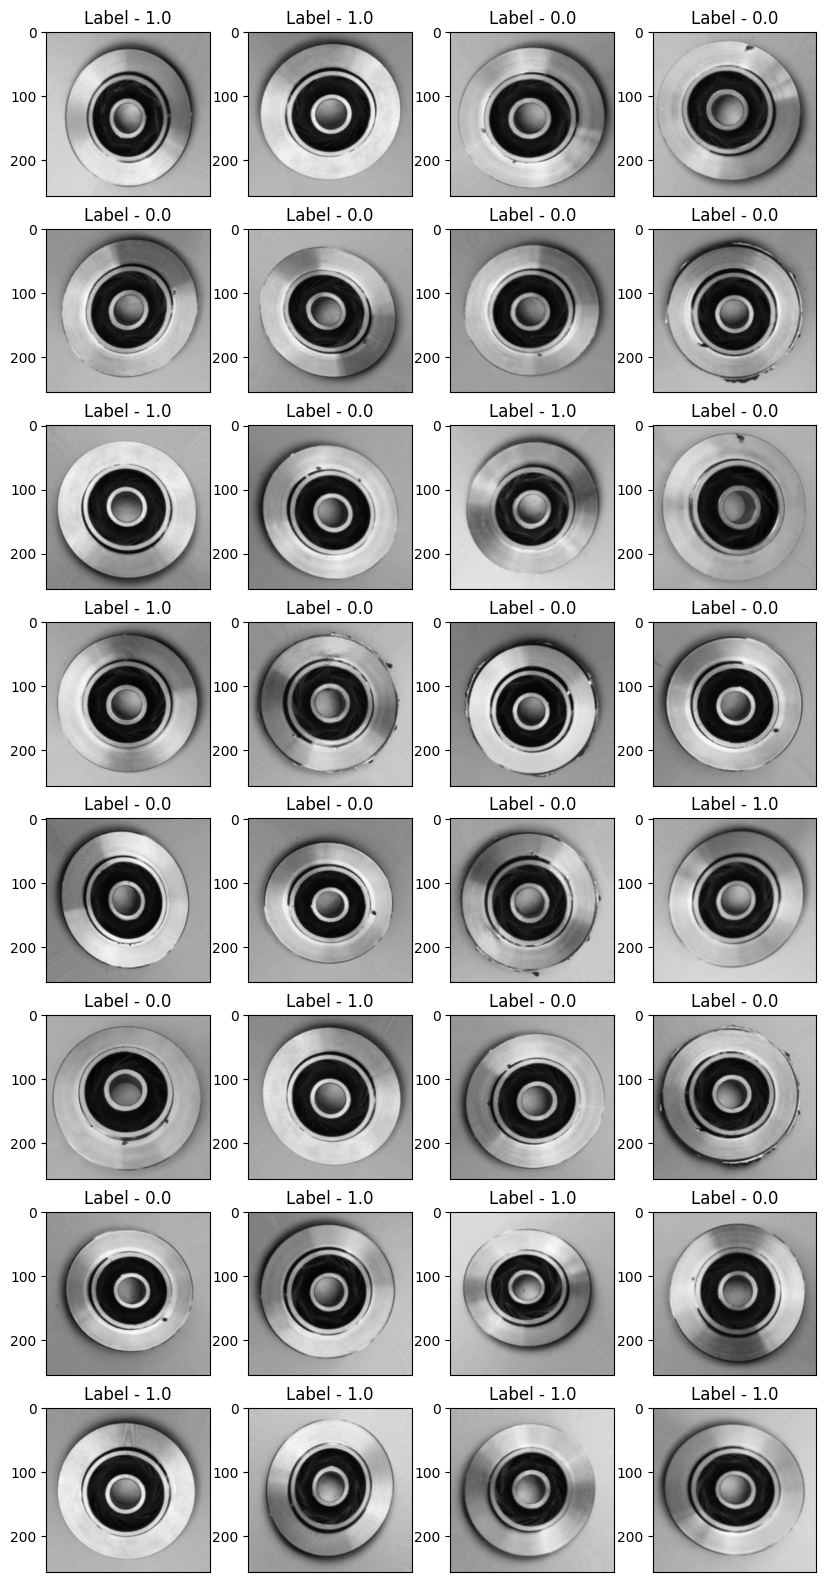

In [23]:
images, labels = next(iter(train_dataset))
fig, ax = plt.subplots(8, 4, figsize = (10, 20))
for i in range(8):
    for j in range(4):
        ax[i][j].imshow(images[4*i+j])
        ax[i][j].set_title(f"Label - {labels[4*i+j]}")
        ax[i][j].set_xticks([])

In [29]:
from tensorflow.keras.applications import MobileNetV2
base_model = MobileNetV2(input_shape = (256, 256, 3), include_top = False, weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1, activation="sigmoid"),
])

model.compile(optimizer="adam",loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 81920)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    20,971,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,230,017 (88.62 MB)

 Trainable params: 20,972,033 (80.00 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [30]:
history=model.fit(train_dataset,
         epochs = 10,
          validation_data = val_dataset
         )

Epoch 1/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 49s 214ms/step - accuracy: 0.8709 - loss: 3.7616 - val_accuracy: 0.9940 - val_loss: 0.0155
Epoch 2/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 64s 144ms/step - accuracy: 0.9930 - loss: 0.0235 - val_accuracy: 0.9947 - val_loss: 0.0148
Epoch 3/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 24s 139ms/step - accuracy: 0.9938 - loss: 0.0170 - val_accuracy: 0.9970 - val_loss: 0.0081
Epoch 4/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 25s 141ms/step - accuracy: 0.9936 - loss: 0.0173 - val_accuracy: 0.9940 - val_loss: 0.0139
Epoch 5/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - accuracy: 0.9952 - loss: 0.0177 - val_accuracy: 0.9947 - val_loss: 0.0180
Epoch 6/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 24s 133ms/step - accuracy: 0.9972 - loss: 0.0116 - val_accuracy: 0.9962 - val_loss: 0.0143
Epoch 7/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 40s 135ms/step - accuracy: 0.9977 - loss: 0.0053 - val_accuracy: 0.9962 - val_loss: 0.0147
Epoch 8/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 43s 147ms/step - accuracy: 0.9943 - loss: 0

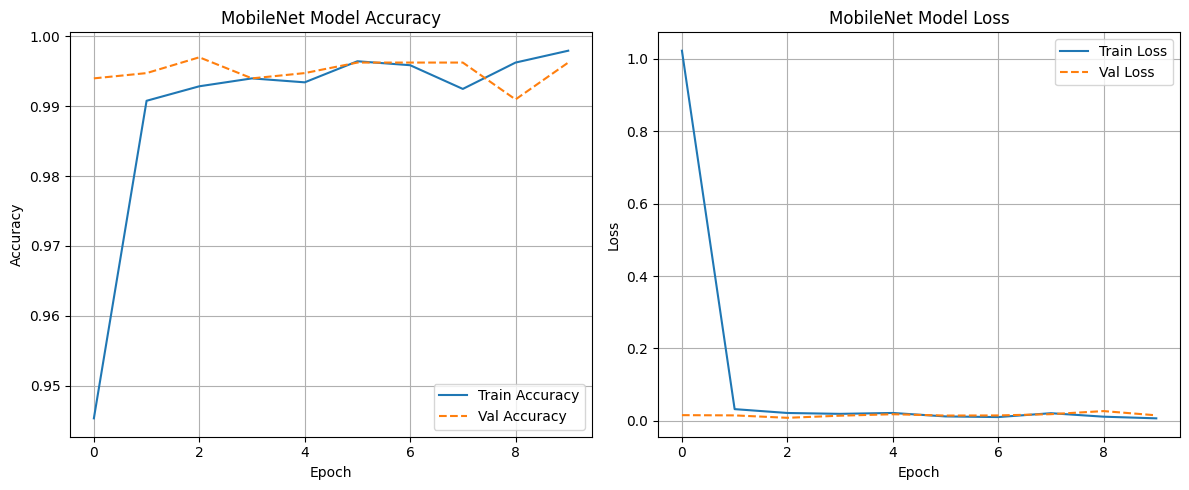

In [31]:
import matplotlib.pyplot as plt

# Plot side-by-side
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy
ax[0].plot(history.history['accuracy'], label='Train Accuracy')
ax[0].plot(history.history.get('val_accuracy', []), label='Val Accuracy', linestyle='--')
ax[0].set_title('MobileNet Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid(True)

# Loss
ax[1].plot(history.history['loss'], label='Train Loss')
ax[1].plot(history.history.get('val_loss', []), label='Val Loss', linestyle='--')
ax[1].set_title('MobileNet Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

In [32]:
from tensorflow.keras.applications import ResNet50
base_model = ResNet50(input_shape = (256, 256, 3), include_top = False, weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1, activation="sigmoid"),
])

model.compile(optimizer="adam",loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │    33,554,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,142,657 (217.98 MB)

 Trainable params: 33,554,945 (128.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
mod=tf.keras.models.load_model("/content/drive/MyDrive/casting_detection.h5")

In [ ]:
model.save("/content/drive/MyDrive/casting_detection_resnet.h5")

In [ ]:
model.save_weights("/content/drive/MyDrive/casting_detection.weights.h5")

In [ ]:
model.save("/content/drive/MyDrive/casting_detection_keras.keras")

In [25]:
history=model.fit(train_dataset,
         epochs = 10,
          validation_data = val_dataset
         )

Epoch 1/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 685s 4s/step - accuracy: 0.5518 - loss: 3.9523 - val_accuracy: 0.5614 - val_loss: 0.6625
Epoch 2/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 28s 158ms/step - accuracy: 0.5687 - loss: 0.6731 - val_accuracy: 0.5614 - val_loss: 0.6900
Epoch 3/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 28s 159ms/step - accuracy: 0.5692 - loss: 0.6888 - val_accuracy: 0.5614 - val_loss: 0.6875
Epoch 4/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 30s 170ms/step - accuracy: 0.5682 - loss: 0.6863 - val_accuracy: 0.5614 - val_loss: 0.6863
Epoch 5/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 29s 167ms/step - accuracy: 0.5645 - loss: 0.6856 - val_accuracy: 0.5614 - val_loss: 0.6858
Epoch 6/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 32s 183ms/step - accuracy: 0.5614 - loss: 0.6858 - val_accuracy: 0.5614 - val_loss: 0.6856
Epoch 7/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 36s 153ms/step - accuracy: 0.5571 - loss: 0.6866 - val_accuracy: 0.5614 - val_loss: 0.6856
Epoch 8/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 42s 161ms/step - accuracy: 0.5637 - loss: 0.6

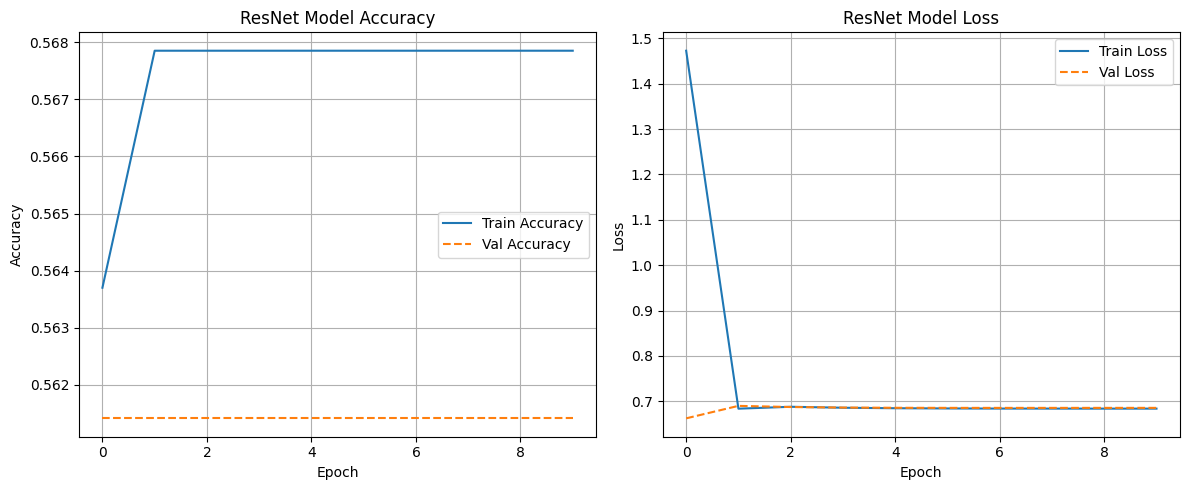

In [26]:
import matplotlib.pyplot as plt

# Plot side-by-side
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy
ax[0].plot(history.history['accuracy'], label='Train Accuracy')
ax[0].plot(history.history.get('val_accuracy', []), label='Val Accuracy', linestyle='--')
ax[0].set_title('ResNet Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid(True)

# Loss
ax[1].plot(history.history['loss'], label='Train Loss')
ax[1].plot(history.history.get('val_loss', []), label='Val Loss', linestyle='--')
ax[1].set_title('ResNet Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

In [33]:
from tensorflow.keras.applications import Xception
base_model = Xception(input_shape = (256, 256, 3), include_top = False, weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1, activation="sigmoid"),
])

model.compile(optimizer="adam",loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 8, 8, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │    33,554,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,416,425 (207.58 MB)

 Trainable params: 33,554,945 (128.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [34]:
history=model.fit(train_dataset,
         epochs = 10,
          validation_data = val_dataset
         )

Epoch 1/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 67s 309ms/step - accuracy: 0.8247 - loss: 4.0691 - val_accuracy: 0.9947 - val_loss: 0.0151
Epoch 2/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 57s 209ms/step - accuracy: 0.9889 - loss: 0.0320 - val_accuracy: 0.9947 - val_loss: 0.0157
Epoch 3/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 41s 212ms/step - accuracy: 0.9911 - loss: 0.0317 - val_accuracy: 0.9977 - val_loss: 0.0112
Epoch 4/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 42s 220ms/step - accuracy: 0.9911 - loss: 0.0255 - val_accuracy: 0.9842 - val_loss: 0.0422
Epoch 5/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 42s 229ms/step - accuracy: 0.9929 - loss: 0.0169 - val_accuracy: 0.9985 - val_loss: 0.0086
Epoch 6/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 39s 219ms/step - accuracy: 0.9948 - loss: 0.0135 - val_accuracy: 0.9962 - val_loss: 0.0147
Epoch 7/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 41s 219ms/step - accuracy: 0.9903 - loss: 0.0251 - val_accuracy: 0.9977 - val_loss: 0.0064
Epoch 8/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 41s 220ms/step - accuracy: 0.9944 - loss: 0

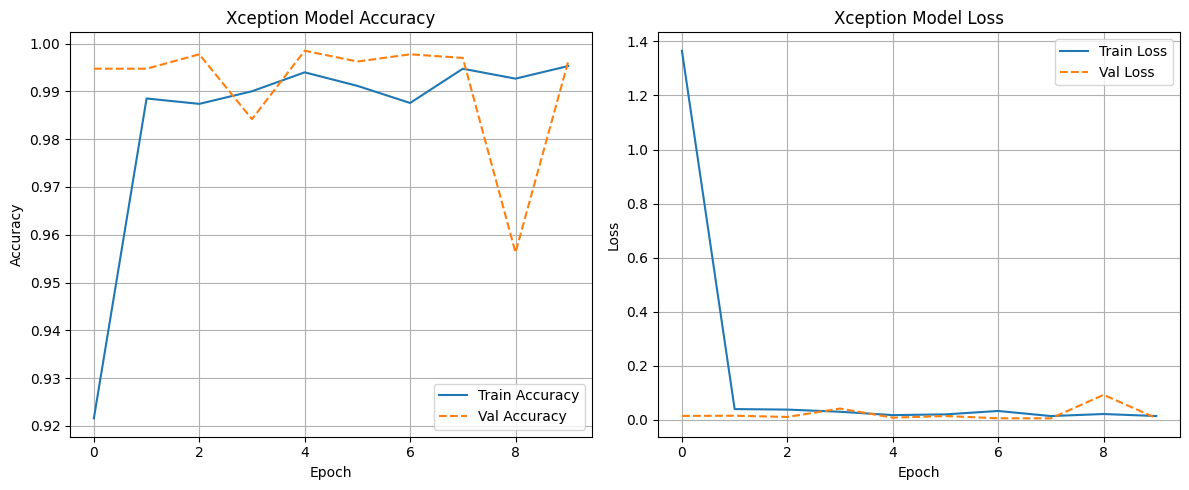

In [35]:
import matplotlib.pyplot as plt

# Plot side-by-side
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy
ax[0].plot(history.history['accuracy'], label='Train Accuracy')
ax[0].plot(history.history.get('val_accuracy', []), label='Val Accuracy', linestyle='--')
ax[0].set_title('Xception Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid(True)

# Loss
ax[1].plot(history.history['loss'], label='Train Loss')
ax[1].plot(history.history.get('val_loss', []), label='Val Loss', linestyle='--')
ax[1].set_title('Xception Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

In [36]:
model.save("/content/drive/MyDrive/casting_detection_XCEPTION.h5")

In [37]:
from tensorflow.keras.applications import efficientnet_v2
base_model = Xception(input_shape = (256, 256, 3), include_top = False, weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1, activation="sigmoid"),
])

model.compile(optimizer="adam",loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 8, 8, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │    33,554,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,416,425 (207.58 MB)

 Trainable params: 33,554,945 (128.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [38]:
history=model.fit(train_dataset,
         epochs = 10,
          validation_data = val_dataset
         )

Epoch 1/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 52s 252ms/step - accuracy: 0.7560 - loss: 6.0359 - val_accuracy: 0.9910 - val_loss: 0.0424
Epoch 2/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 36s 206ms/step - accuracy: 0.9813 - loss: 0.0586 - val_accuracy: 0.9970 - val_loss: 0.0237
Epoch 3/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 42s 215ms/step - accuracy: 0.9864 - loss: 0.0455 - val_accuracy: 0.9932 - val_loss: 0.0227
Epoch 4/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 42s 223ms/step - accuracy: 0.9881 - loss: 0.0386 - val_accuracy: 0.9985 - val_loss: 0.0173
Epoch 5/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 37s 215ms/step - accuracy: 0.9938 - loss: 0.0292 - val_accuracy: 0.9977 - val_loss: 0.0140
Epoch 6/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 41s 216ms/step - accuracy: 0.9920 - loss: 0.0270 - val_accuracy: 0.9962 - val_loss: 0.0125
Epoch 7/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 39s 230ms/step - accuracy: 0.9937 - loss: 0.0243 - val_accuracy: 0.9970 - val_loss: 0.0105
Epoch 8/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 41s 229ms/step - accuracy: 0.9927 - loss: 0

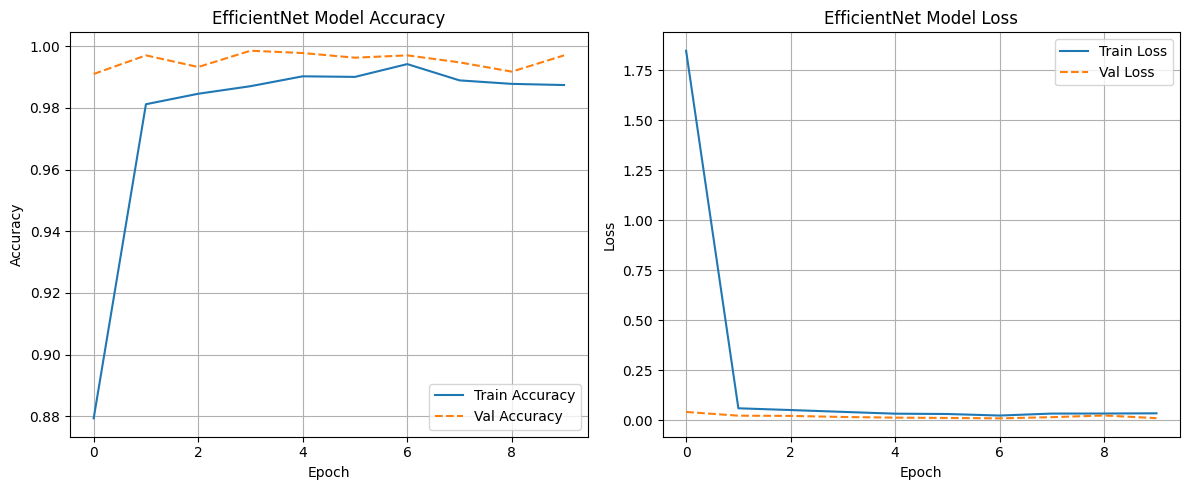

In [39]:
import matplotlib.pyplot as plt

# Plot side-by-side
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy
ax[0].plot(history.history['accuracy'], label='Train Accuracy')
ax[0].plot(history.history.get('val_accuracy', []), label='Val Accuracy', linestyle='--')
ax[0].set_title('EfficientNet Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid(True)

# Loss
ax[1].plot(history.history['loss'], label='Train Loss')
ax[1].plot(history.history.get('val_loss', []), label='Val Loss', linestyle='--')
ax[1].set_title('EfficientNet Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

In [40]:
model.save("/content/drive/MyDrive/casting_detection_EfficentNet.h5")

In [ ]:
import matplotlib.pyplot as plt
class GradCAM:
  def __init__(self,model,classIdx,layer_name=None):
    self.model=model
    self.classIdx=classIdx
    self.layer_name=layer_name
    if self.layer_name is None:
      self.layer_name=self.find_target_layer()
  def find_target_layer(self):

    for layer in reversed(self.model.get_layer("mobilenetv2_1.00_224").layers):
      if (len(layer.output.shape)==4):
        print(layer.input.shape,layer.output.shape,layer.name)
        return layer.name

  def compute_heatmap(self,image,eps=1e-8):

    feature_extractor=self.model.layers[0]
    gradModel=tf.keras.models.Model(inputs=[self.model.layers[1].input],outputs=[self.model.layers[-1].output])
    with tf.GradientTape() as tape:


      inputs=tf.cast(image,tf.float32)
      tape.watch(inputs)
      convOutput=feature_extractor(inputs)
      tape.watch(convOutput)
      predictions=gradModel(convOutput)
      loss=predictions[:,self.classIdx]

    grads=tape.gradient(loss,convOutput)
    castConv=tf.cast(convOutput>0,tf.float32)
    castgrad=tf.cast(grads>0,tf.float32)
    guidedGrads = castConv * castgrad * grads

    convOutput = convOutput[0]
    guidedGrads = guidedGrads[0]
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutput), axis=-1)
    (w, h) = (image.shape[2], image.shape[1])
    heatmap=cv2.resize(cam.numpy(),(w,h))
    numr=heatmap - np.min(heatmap)
    deno=(heatmap.max()-heatmap.min())+eps

    heatmap=((numr/deno)*(255.0)).astype("uint8")

    return heatmap
  def overlayed_heatmap(self,image,heatmap,alpha=0.5,
		colormap=cv2.COLORMAP_VIRIDIS):
    print(image.shape,heatmap.shape)
    heatmap=cv2.applyColorMap(heatmap,colormap)
    plt.imshow(heatmap)
    plt.show()
    image=(image*255).astype("uint8")
    print(image.shape,heatmap.shape)
    output=cv2.addWeighted(image,alpha,heatmap,1-alpha,0)
    return (heatmap,output)





In [ ]:
gradModel=tf.keras.models.Model(inputs=[mod.layers[2].input],outputs=mod.outputs)
img,label=load_image("/content/499081a17c668a32b81f721323eeef56dd5609ce02855a025bd7185c.jpg",1)
img=tf.expand_dims(img,axis=0)
inp=mod.layers[0](img)
inp=tf.keras.layers.Flatten()(inp)


In [ ]:
model.set_weights(mod.get_weights())


In [ ]:
img,label=load_image("/content/499081a17c668a32b81f721323eeef56dd5609ce02855a025bd7185c.jpg",1)
img=tf.expand_dims(img,axis=0)
mod(img)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[3.556153e-10]], dtype=float32)>

(None, 8, 8, 1280) (None, 8, 8, 1280) out_relu
(256, 256, 3) (256, 256)


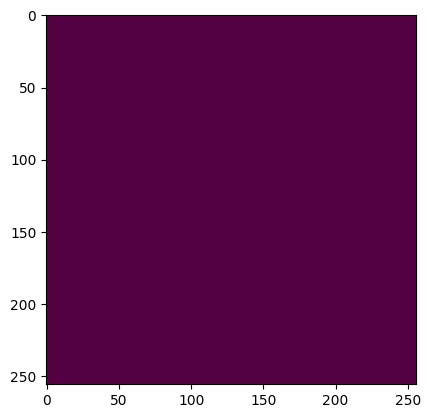

(256, 256, 3) (256, 256, 3)


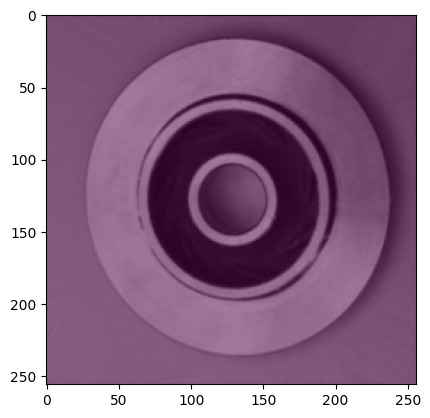

In [ ]:
import cv2
grad_cam=GradCAM(model,0)
img,label=load_image("/content/drive/MyDrive/archive_2/casting_data/casting_data/train/ok_front/cast_ok_0_8168.jpeg",1)
img=tf.expand_dims(img,axis=0)
heatmap=grad_cam.compute_heatmap(img)

heatmap,output=grad_cam.overlayed_heatmap(img.numpy().reshape(256,256,3),heatmap)
plt.imshow(output)
plt.show()

In [ ]:
import os
os.listdir("/content/drive/MyDrive/archive_2/casting_data/casting_data/train/ok_front/cast_ok_0_8168.jpeg")

NotADirectoryError: [Errno 20] Not a directory: '/content/drive/MyDrive/archive_2/casting_data/casting_data/train/ok_front/cast_ok_0_8168.jpeg'

In [ ]:
!pip install tf_keras_vis

In [ ]:
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

# Define score function (binary or multi-class)
score = lambda output: output[:, 0]

# Replace final activation with linear to help backprop
replace2linear = ReplaceToLinear()

# Create GradCAM object
gradcam = Gradcam(model, model_modifier=replace2linear)

# Generate heatmap
cam = gradcam(score, image, penultimate_layer='Conv_1')

# Post-process
import matplotlib.pyplot as plt
plt.imshow(cam[0], cmap='jet')


AttributeError: 'Sequential' object has no attribute 'output_names'

In [ ]:
model.inputs

[<KerasTensor shape=(None, 256, 256, 3), dtype=float32, sparse=False, name=keras_tensor_154>]

In [ ]:
model(img)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>

In [ ]:
model.save("/content/drive/MyDrive/casting_detection.h5")

In [ ]:
model.save("/content/drive/MyDrive/casting_detection.keras")

In [ ]:
xtest, ytest = next(iter(val_dataset))

In [ ]:
ypred = model.predict(xtest)
ypred = np.squeeze(ypred)

1/1 [==============================] - 1s 845ms/step


In [ ]:
for i in range(0, len(ypred)):
    if ypred[i] > 0.5:
        ypred[i] = 1
    else:
        ypred[i] = 0

In [ ]:
from sklearn.metrics import classification_report
rep = pd.DataFrame(classification_report(ytest, ypred, output_dict = True))
rep

,0.0,1.0,accuracy,macro avg,weighted avg
precision,1.0,1.0,1.0,1.0,1.0
recall,1.0,1.0,1.0,1.0,1.0
f1-score,1.0,1.0,1.0,1.0,1.0
support,18.0,14.0,1.0,32.0,32.0


In [ ]:
ypred

array([0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0.],
      dtype=float32)

In [ ]:
result = []
for i in range(len(ypred)):
    if ypred[i] == 0:
        result.append("DEFECTIVE")
    else:
        result.append("NON-DEFECTIVE")
result

['DEFECTIVE',
 'NON-DEFECTIVE',
 'DEFECTIVE',
 'NON-DEFECTIVE',
 'DEFECTIVE',
 'DEFECTIVE',
 'DEFECTIVE',
 'NON-DEFECTIVE',
 'DEFECTIVE',
 'DEFECTIVE',
 'DEFECTIVE',
 'DEFECTIVE',
 'NON-DEFECTIVE',
 'DEFECTIVE',
 'DEFECTIVE',
 'DEFECTIVE',
 'NON-DEFECTIVE',
 'NON-DEFECTIVE',
 'DEFECTIVE',
 'NON-DEFECTIVE',
 'DEFECTIVE',
 'NON-DEFECTIVE',
 'NON-DEFECTIVE',
 'NON-DEFECTIVE',
 'NON-DEFECTIVE',
 'NON-DEFECTIVE',
 'DEFECTIVE',
 'DEFECTIVE',
 'NON-DEFECTIVE',
 'NON-DEFECTIVE',
 'DEFECTIVE',
 'DEFECTIVE']

In [ ]:
true = []
for i in range(len(ytest)):
    if ytest[i] == 0:
        true.append("DEFECTIVE")
    else:
        true.append("NON-DEFECTIVE")

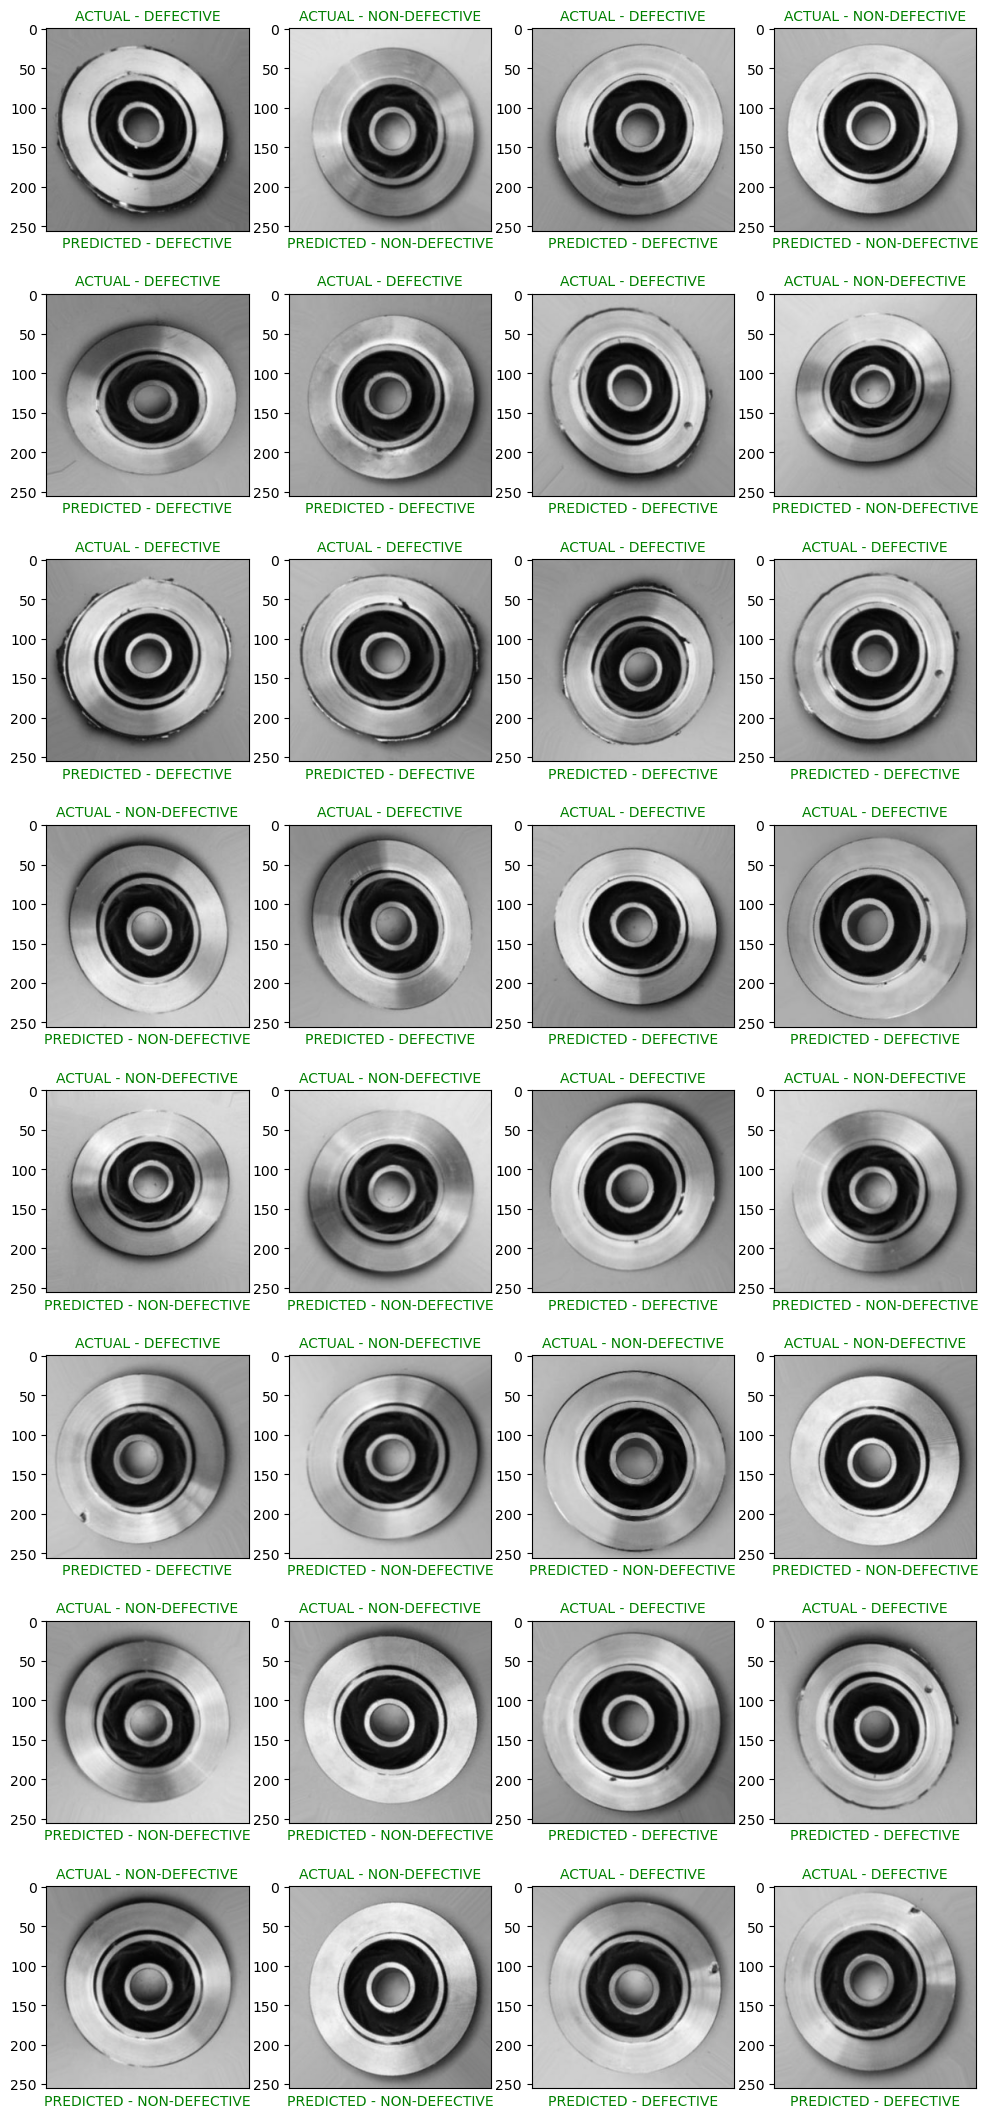

In [ ]:
fig, ax = plt.subplots(8, 4, figsize = (12, 27))
for i in range(8):
    for j in range(4):
        ax[i][j].imshow(xtest[4*i+j])
        if ytest[4*i+j] == ypred[4*i+j]:
            ax[i][j].set_title(f"ACTUAL - {(result)[4*i+j]}", color = "green", size = 10)
            ax[i][j].set_xlabel(f"PREDICTED - {true[4*i+j]}", color = "green", size = 10)
        else:
            ax[i][j].set_title(f"ACTUAL - {(result)[4*i+j]}", color = "red", size = 10)
            ax[i][j].set_xlabel(f"PREDICTED - {true[4*i+j]}", color = "red", size = 10)
        ax[i][j].set_xticks([])